In [1]:
import logging
logging.basicConfig(level=logging.DEBUG)

import graphcat.notebook

graph = graphcat.StaticGraph()
logger = graphcat.Logger(graph)

graph.set_expression("expr", "3 + 4")
graphcat.notebook.display(graph)

Here, we've created a single task that will return the value of the expression `3 + 4`:

In [2]:
print("Output:", graph.output("expr"))
graphcat.notebook.display(graph)

INFO:graphcat.common:Task expr updating.
INFO:graphcat.common:Task expr executing. Inputs: {}
INFO:graphcat.common:Task expr finished. Output: 7


Output: 7


If we change the expression, the task becomes unfinished until the next time it's executed, just as you'd normally expect:

In [3]:
graph.set_expression("expr", "'Hello' + ' ' + 'World!'")
graphcat.notebook.display(graph)

In [4]:
print("Output:", graph.output("expr"))

INFO:graphcat.common:Task expr updating.
INFO:graphcat.common:Task expr executing. Inputs: {}
INFO:graphcat.common:Task expr finished. Output: Hello World!


Output: Hello World!


Of course, an expression task wouldn't be of much use if it didn't have inputs ... let's create an expression task that converts its input to an integer:

In [5]:
import math

graph.set_expression("expr", "int(inputs.getone(None))")
graph.set_task("A", graphcat.constant(math.pi))
graph.set_links("A", "expr")

print("Output:", graph.output("expr"))
graphcat.notebook.display(graph)

INFO:graphcat.common:Task A updating.
INFO:graphcat.common:Task A executing. Inputs: {}
INFO:graphcat.common:Task A finished. Output: 3.141592653589793
INFO:graphcat.common:Task expr updating.
INFO:graphcat.common:Task expr executing. Inputs: {None: 3.141592653589793}
INFO:graphcat.common:Task expr finished. Output: 3


Output: 3


In [6]:
graph.set_expression("expr", "f'Task {name!r} input: {inputs.getone(None):.4f}'")

print("Output:", graph.output("expr"))
graphcat.notebook.display(graph)

INFO:graphcat.common:Task A updating.
INFO:graphcat.common:Task expr updating.
INFO:graphcat.common:Task expr executing. Inputs: {None: 3.141592653589793}
INFO:graphcat.common:Task expr finished. Output: Task 'expr' input: 3.1416


Output: Task 'expr' input: 3.1416


INFO:graphcat.common:Task expr updating.
INFO:graphcat.common:Task expr executing. Inputs: {0, 1, 'choice'}
INFO:graphcat.common:Task choice updating.
INFO:graphcat.common:Task choice executing. Inputs: {}
INFO:graphcat.common:Task choice finished. Output: 0
INFO:graphcat.common:Task A updating.
INFO:graphcat.common:Task A executing. Inputs: {}
INFO:graphcat.common:Task A finished. Output: A
INFO:graphcat.common:Task expr finished. Output: A


Output: A


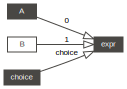

In [7]:
graph = graphcat.DynamicGraph()
logger = graphcat.Logger(graph)

graph.set_task("A", graphcat.constant("A"))
graph.set_task("B", graphcat.constant("B"))
graph.set_task("choice", graphcat.constant(0))
graph.set_expression("expr", "inputs.getone(inputs.getone('choice'))")

graph.add_links("A", ("expr", 0))
graph.add_links("B", ("expr", 1))
graph.add_links("choice", ("expr", "choice"))

print("Output:", graph.output("expr"))
graphcat.notebook.display(graph)

... and if we change the value of the "choice" task:

INFO:graphcat.common:Task expr updating.
INFO:graphcat.common:Task expr executing. Inputs: {0, 1, 'choice'}
INFO:graphcat.common:Task choice updating.
INFO:graphcat.common:Task choice executing. Inputs: {}
INFO:graphcat.common:Task choice finished. Output: 1
INFO:graphcat.common:Task B updating.
INFO:graphcat.common:Task B executing. Inputs: {}
INFO:graphcat.common:Task B finished. Output: B
INFO:graphcat.common:Task expr finished. Output: B


Output: B


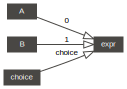

In [8]:
graph.set_task("choice", graphcat.constant(1))

print("Output:", graph.output("expr"))
graphcat.notebook.display(graph)

As we mentioned earlier, an expression task has access to the same arguments as any task, *including the graph object itself*.  What do you think will happen when we execute the expression in the following graph?

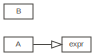

In [9]:
graph.clear_tasks()
graph.set_task("A", graphcat.constant(2))
graph.set_task("B", graphcat.constant(3))
graph.set_expression("expr", 'inputs.getone(None) * graph.output("B")')
graph.set_links("A", "expr")

graphcat.notebook.display(graph)

There isn't a link (dependency) between "B" and the expression task, but the expression is using the graph object to directly access the output from "B".  If we execute the expression, we will get the expected result:

In [10]:
print("Output:", graph.output("expr"))

INFO:graphcat.common:Task expr updating.
INFO:graphcat.common:Task expr executing. Inputs: {None}
INFO:graphcat.common:Task A updating.
INFO:graphcat.common:Task A executing. Inputs: {}
INFO:graphcat.common:Task A finished. Output: 2
INFO:graphcat.common:Task B updating.
INFO:graphcat.common:Task B executing. Inputs: {}
INFO:graphcat.common:Task B finished. Output: 3
INFO:graphcat.common:Task expr finished. Output: 6


Output: 6


Two times three does equal six.  However, you should be concerned that this introduces an implicit dependency between the "upstream" tasks "B" and the expression task - the point of a computational graph is that dependencies are explicitly captured by the links in the graph.  Without those links, a change to an upstream task won't trigger changes to downstream tasks that depend on it.  Or will it?  Let's change "B" and see what happens:

In [11]:
graph.set_task("B", graphcat.constant(5))
print("Output:", graph.output("expr"))

INFO:graphcat.common:Task expr updating.
INFO:graphcat.common:Task expr executing. Inputs: {None, <Input.IMPLICIT: 1>}
INFO:graphcat.common:Task A updating.
INFO:graphcat.common:Task B updating.
INFO:graphcat.common:Task B executing. Inputs: {}
INFO:graphcat.common:Task B finished. Output: 5
INFO:graphcat.common:Task expr finished. Output: 10


Output: 10


Interesting - we got the correct result.  Let's take a look at the graph diagram to see what happened:

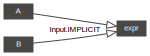

In [12]:
graphcat.notebook.display(graph)

The expression task has added an edge to capture the implicit dependency introduced by the code in the expression!  This edge ensures that changes to the upstream task cause affect the expression task.